1. ВВОДНАЯ ЧАСТЬ

                          ПРАКТИЧЕСКАЯ РАБОТА
"Исследование влияния различных факторов на качество изображения с помощью автокодировщиков с глубокими сверточными сетями"


Автор: Илья Мацнев


Краткая аннотация:
В данной работе исследуется влияние различных факторов (размер изображения, уровень шума) на качество повышения разрешения изображений с использованием автокодировщиков на основе глубоких сверточных сетей. Работа включает подготовку данных, реализацию модели, обучение и анализ результатов.

2. УСТАНОВКА И ИМПОРТ БИБЛИОТЕК

In [ ]:
# @title Установка необходимых библиотек
!pip install tensorflow keras numpy matplotlib scikit-image opencv-python tqdm

# Импорт основных библиотек
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.util import random_noise
from tqdm import tqdm
import os

3. ТЕОРЕТИЧЕСКАЯ ЧАСТЬ


**Краткое описание проблемы**

Повышение качества изображений, включая устранение шума и увеличение разрешения, является важной задачей в компьютерном зрении. Автокодировщики позволяют эффективно решать эту задачу.

**Основные концепции**

Автокодировщик — это нейронная сеть, которая учится сжимать данные в латентное пространство и восстанавливать их. В данной работе используется сверточный автокодировщик для улучшения качества изображений.

**Математическое обоснование**

Модель обучается минимизировать функцию потерь, например, MSE (Mean Squared Error), между исходным и восстановленным изображением.

**Схема архитектуры**

Энкодер: Сверточные слои для уменьшения размерности.

Латентное пространство: Компактное представление изображения.

Декодер: Слои увеличения разрешения (UpSampling2D).



4. ПОДГОТОВКА ДАННЫХ

**Загрузка датасета, получение данных, обработка, визуализация, разделение выборки.**

Используем датасет CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html), который содержит изображения низкого разрешения.

In [ ]:
from tensorflow.keras.datasets import cifar10

# Загрузка CIFAR-10
(train_images, _), (test_images, _) = cifar10.load_data()
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
print(f"Количество изображений для обучения: {len(train_images)}")
print(f"Количество изображений для тестирования: {len(test_images)}")

Количество изображений для обучения: 50000
Количество изображений для тестирования: 10000


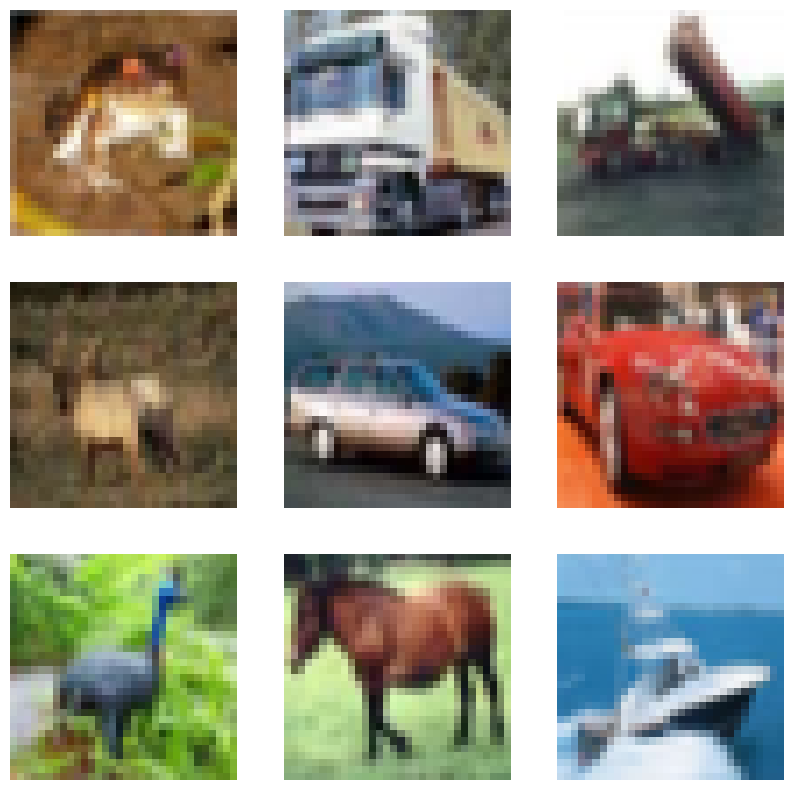

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_images[i])
    plt.axis('off')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# Разделение на обучающую и валидационную выборки
train_images, val_images = train_test_split(train_images, test_size=0.1, random_state=42)

print(f"Количество изображений для обучения: {len(train_images)}")
print(f"Количество изображений для валидации: {len(val_images)}")
print(f"Количество изображений для тестирования: {len(test_images)}")

Количество изображений для обучения: 45000
Количество изображений для валидации: 5000
Количество изображений для тестирования: 10000


5. РЕАЛИЗАЦИЯ МОДЕЛИ

In [ ]:
# @title Определение архитектуры
def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape)

    # Энкодер
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Латентное пространство
    encoded = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    # Декодер
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    return Model(input_img, decoded)

# Создание модели
autoencoder = build_autoencoder((32, 32, 3))
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 3)           │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 742,915 (2.83 MB)

 Trainable params: 742,147 (2.83 MB)

 Non-trainable params: 768 (3.00 KB)

6. ОБУЧЕНИЕ

In [ ]:
# @title Процесс обучения
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history = autoencoder.fit(
    train_images, train_images,
    epochs=10,
    batch_size=32,
    validation_data=(val_images, val_images)
)

Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 51s 30ms/step - loss: 0.0033 - val_loss: 8.0361e-04
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 69s 26ms/step - loss: 9.7611e-04 - val_loss: 8.8182e-04
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 42s 26ms/step - loss: 7.6793e-04 - val_loss: 0.0018
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - loss: 5.6009e-04 - val_loss: 1.5139e-04
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 37s 27ms/step - loss: 3.5192e-04 - val_loss: 2.5688e-04
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - loss: 2.9964e-04 - val_loss: 2.1078e-04
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - loss: 3.0919e-04 - val_loss: 1.1881e-04
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - loss: 2.3673e-04 - val_loss: 1.7323e-04
Epoch 9/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 37s 26ms/step - loss: 1.7681e-04 - val_loss: 3.6524e-04
Epoch 10/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - loss: 2.0340e-04 - val_loss: 1.3277e-04


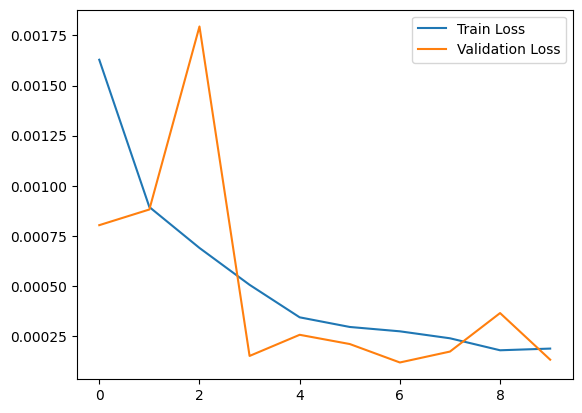

In [ ]:
# @title Визуализация процесса
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

7. ОЦЕНКА РЕЗУЛЬТАТОВ

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


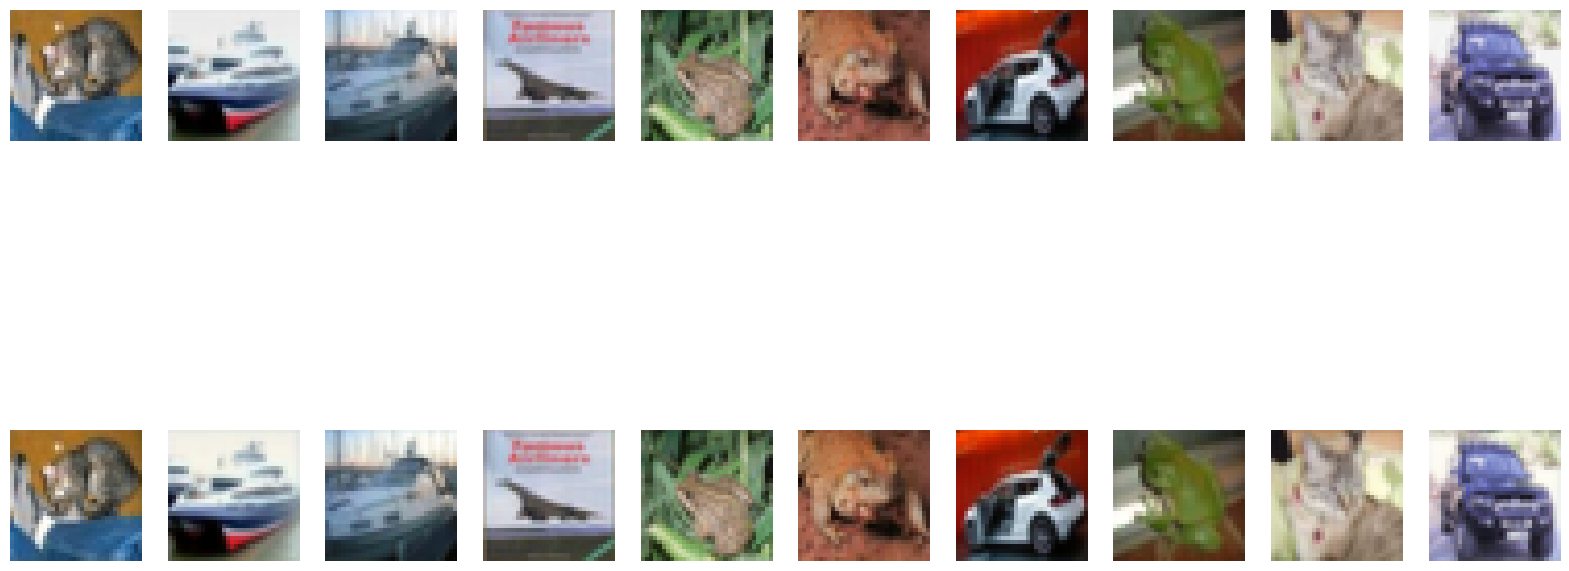

In [ ]:
# @title Визуализация предсказаний
predictions = autoencoder.predict(test_images[:10])

plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_images[i])
    plt.axis('off')
    plt.subplot(2, 10, i+11)
    plt.imshow(predictions[i])
    plt.axis('off')
plt.show()

In [ ]:
# @title Расчёт выводов и метрик
# Ограничиваем тестовый вывод первыми 10 изображениями
test_images_subset = test_images[:10]

# Проверка размеров
print(f"Размер test_images_subset: {test_images_subset.shape}")
print(f"Размер predictions: {predictions.shape}")

# Если размеры не совпадают, меняем их
if test_images_subset.shape != predictions.shape:
    from skimage.transform import resize
    predictions = np.array([resize(predictions[i], test_images_subset[i].shape[:2]) for i in range(len(test_images_subset))])

# Проверка диапазона значений
print(f"Минимальное значение в test_images_subset: {np.min(test_images_subset)}")
print(f"Максимальное значение в test_images_subset: {np.max(test_images_subset)}")
print(f"Минимальное значение в predictions: {np.min(predictions)}")
print(f"Максимальное значение в predictions: {np.max(predictions)}")

# Нормализация значений
test_images_subset = test_images_subset.astype('float32') / 255.0
predictions = predictions.astype('float32') / 255.0

# Проверка типа данных
print(f"Тип данных test_images_subset: {test_images_subset.dtype}")
print(f"Тип данных predictions: {predictions.dtype}")

# Расчет PSNR
from skimage.metrics import peak_signal_noise_ratio as psnr

psnr_values = [psnr(test_images_subset[i], predictions[i]) for i in range(len(test_images_subset))]
print(f"Средний PSNR: {np.mean(psnr_values)}")

Размер test_images_subset: (10, 32, 32, 3)
Размер predictions: (10, 32, 32, 3)
Минимальное значение в test_images_subset: 0.0
Максимальное значение в test_images_subset: 1.0
Минимальное значение в predictions: 8.06701407896071e-08
Максимальное значение в predictions: 0.9999916553497314
Тип данных test_images_subset: float32
Тип данных predictions: float32
Средний PSNR: 86.99412756795293


9. ИССЛЕДОВАНИЯ

Подготовка данных:

Возьмем 10 изображений из тестового набора.

Применим к ним разлинчые факторы: изменение размера, качества, добавление уровня шума и размытости.

Оценка результатов:

Рассчитаем PSNR и SSIM для каждого фактора отдельно.

Визуализируем результаты.

Сделаем финальные выводы

In [ ]:
# Выборка из 10 изображений
sample_images = test_images[:10]

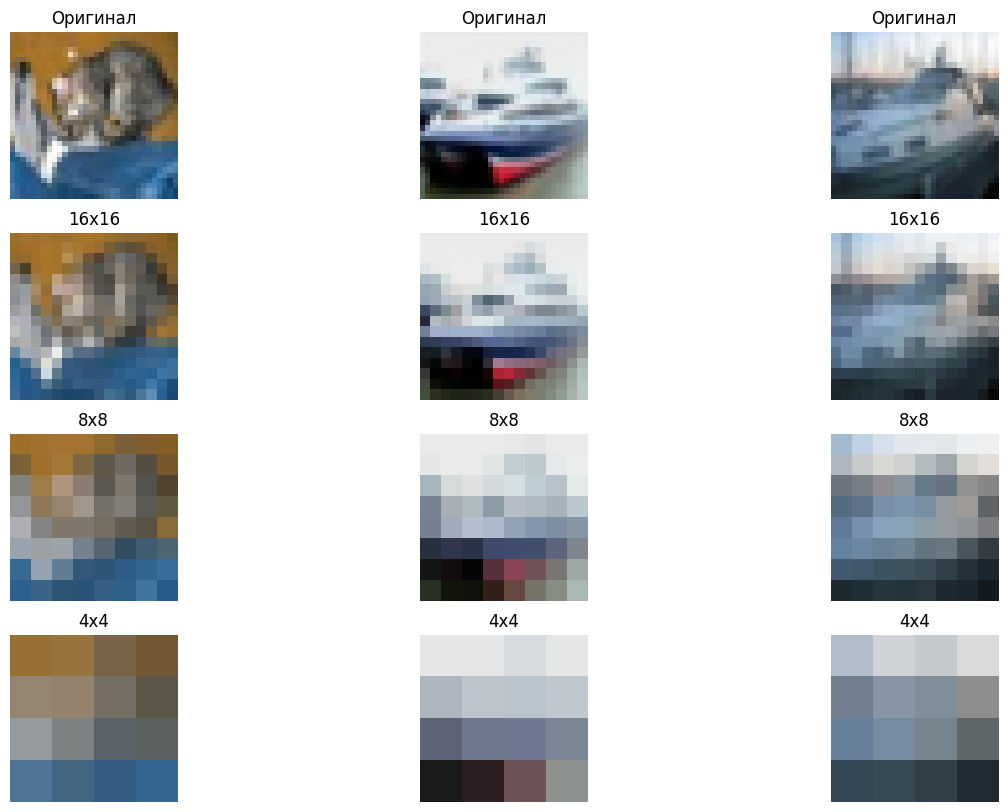

In [ ]:
# @title Фактор разрешения
from skimage.transform import resize

# Уменьшение разрешения до 16x16, 8x8 и 4x4
low_res_16 = np.array([resize(img, (16, 16)) for img in sample_images])
low_res_8 = np.array([resize(img, (8, 8)) for img in sample_images])
low_res_4 = np.array([resize(img, (4, 4)) for img in sample_images])

# Визуализация
plt.figure(figsize=(15, 10))
for i in range(3):  # Покажем первые 3 изображения для наглядности
    plt.subplot(4, 3, i+1)
    plt.imshow(sample_images[i])
    plt.title("Оригинал")
    plt.axis('off')
    plt.subplot(4, 3, i+4)
    plt.imshow(low_res_16[i])
    plt.title("16x16")
    plt.axis('off')
    plt.subplot(4, 3, i+7)
    plt.imshow(low_res_8[i])
    plt.title("8x8")
    plt.axis('off')
    plt.subplot(4, 3, i+10)
    plt.imshow(low_res_4[i])
    plt.title("4x4")
    plt.axis('off')
plt.show()

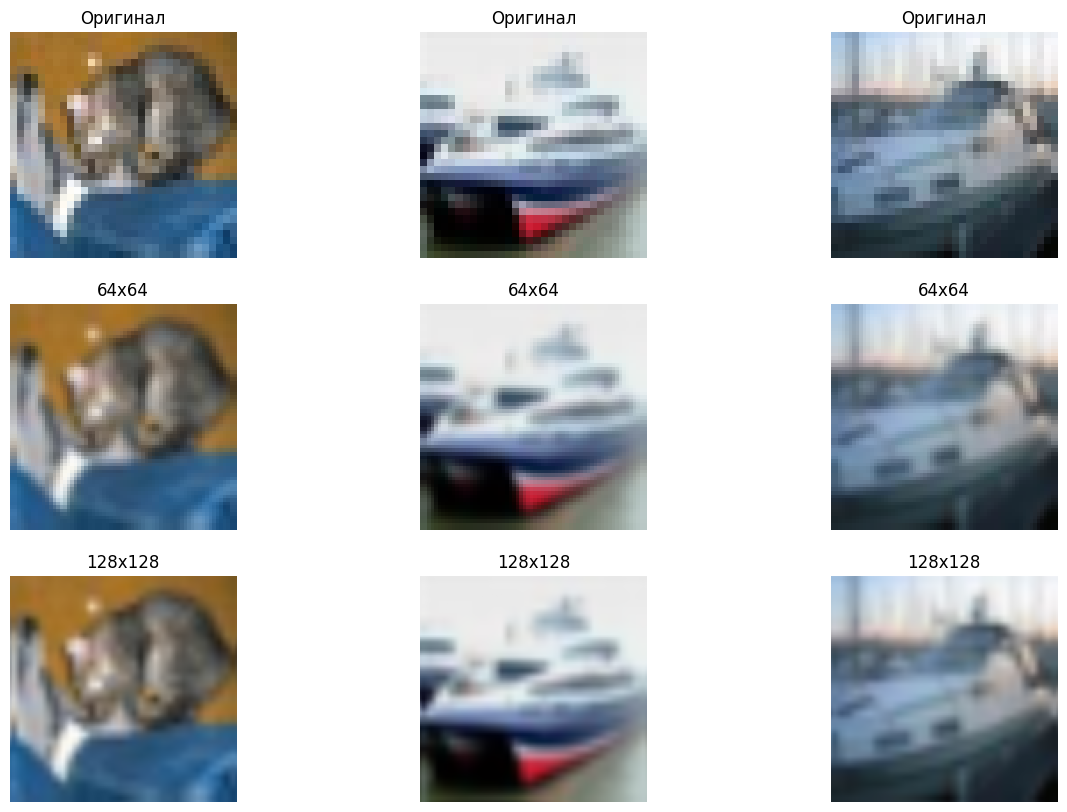

In [ ]:
# Увеличение разрешения до 64x64 и 128x128
high_res_64 = np.array([resize(img, (64, 64)) for img in sample_images])
high_res_128 = np.array([resize(img, (128, 128)) for img in sample_images])

# Визуализация
plt.figure(figsize=(15, 10))
for i in range(3):  # Покажем первые 3 изображения для наглядности
    plt.subplot(3, 3, i+1)
    plt.imshow(sample_images[i])
    plt.title("Оригинал")
    plt.axis('off')
    plt.subplot(3, 3, i+4)
    plt.imshow(high_res_64[i])
    plt.title("64x64")
    plt.axis('off')
    plt.subplot(3, 3, i+7)
    plt.imshow(high_res_128[i])
    plt.title("128x128")
    plt.axis('off')
plt.show()

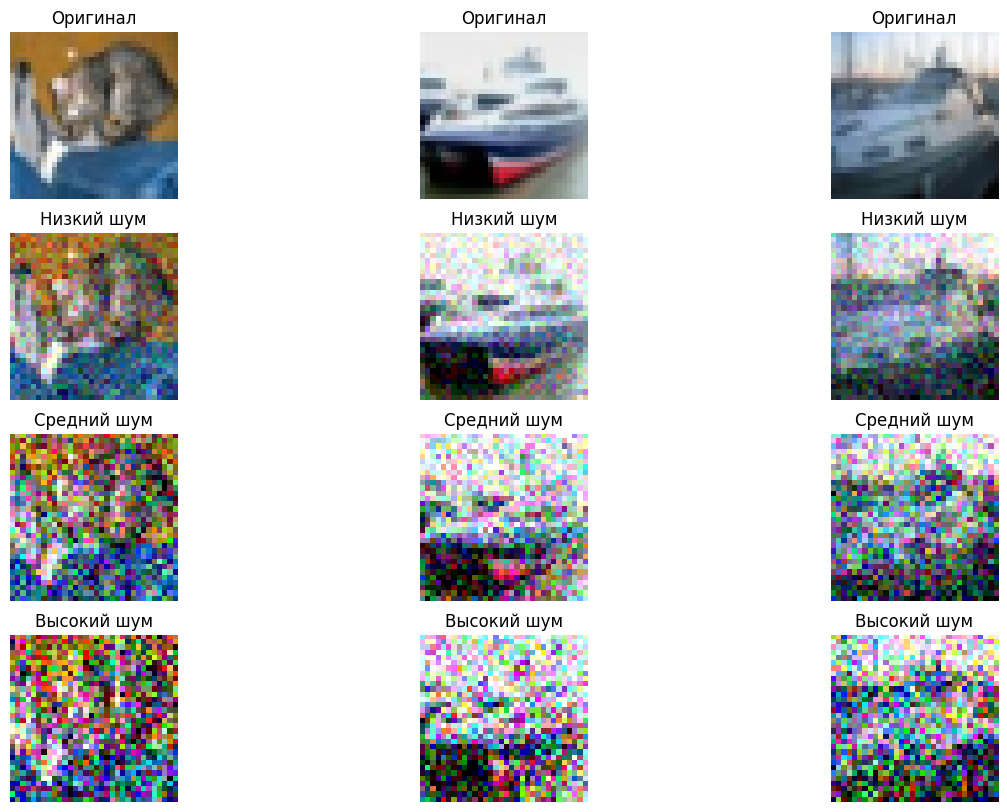

In [ ]:
# @title Фактор шума
from skimage.util import random_noise

# Добавление шума (низкий, средний, высокий уровень)
noisy_low = np.array([random_noise(img, mode='gaussian', var=0.01) for img in sample_images])
noisy_medium = np.array([random_noise(img, mode='gaussian', var=0.05) for img in sample_images])
noisy_high = np.array([random_noise(img, mode='gaussian', var=0.1) for img in sample_images])

# Визуализация
plt.figure(figsize=(15, 10))
for i in range(3):  # Покажем первые 3 изображения для наглядности
    plt.subplot(4, 3, i+1)
    plt.imshow(sample_images[i])
    plt.title("Оригинал")
    plt.axis('off')
    plt.subplot(4, 3, i+4)
    plt.imshow(noisy_low[i])
    plt.title("Низкий шум")
    plt.axis('off')
    plt.subplot(4, 3, i+7)
    plt.imshow(noisy_medium[i])
    plt.title("Средний шум")
    plt.axis('off')
    plt.subplot(4, 3, i+10)
    plt.imshow(noisy_high[i])
    plt.title("Высокий шум")
    plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


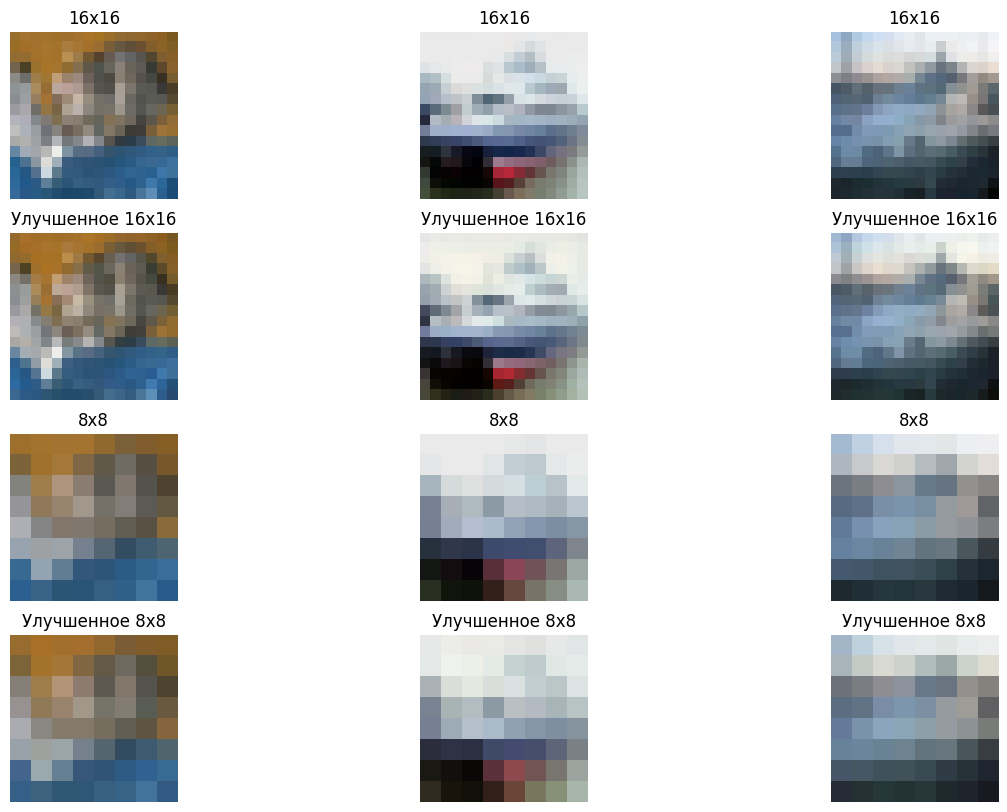

In [ ]:
# @title Фактор качества
# Повышение разрешения
enhanced_low_res_16 = autoencoder.predict(low_res_16)
enhanced_low_res_8 = autoencoder.predict(low_res_8)
enhanced_low_res_4 = autoencoder.predict(low_res_4)

# Визуализация
plt.figure(figsize=(15, 10))
for i in range(3):  # Покажем первые 3 изображения для наглядности
    plt.subplot(4, 3, i+1)
    plt.imshow(low_res_16[i])
    plt.title("16x16")
    plt.axis('off')
    plt.subplot(4, 3, i+4)
    plt.imshow(enhanced_low_res_16[i])
    plt.title("Улучшенное 16x16")
    plt.axis('off')
    plt.subplot(4, 3, i+7)
    plt.imshow(low_res_8[i])
    plt.title("8x8")
    plt.axis('off')
    plt.subplot(4, 3, i+10)
    plt.imshow(enhanced_low_res_8[i])
    plt.title("Улучшенное 8x8")
    plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


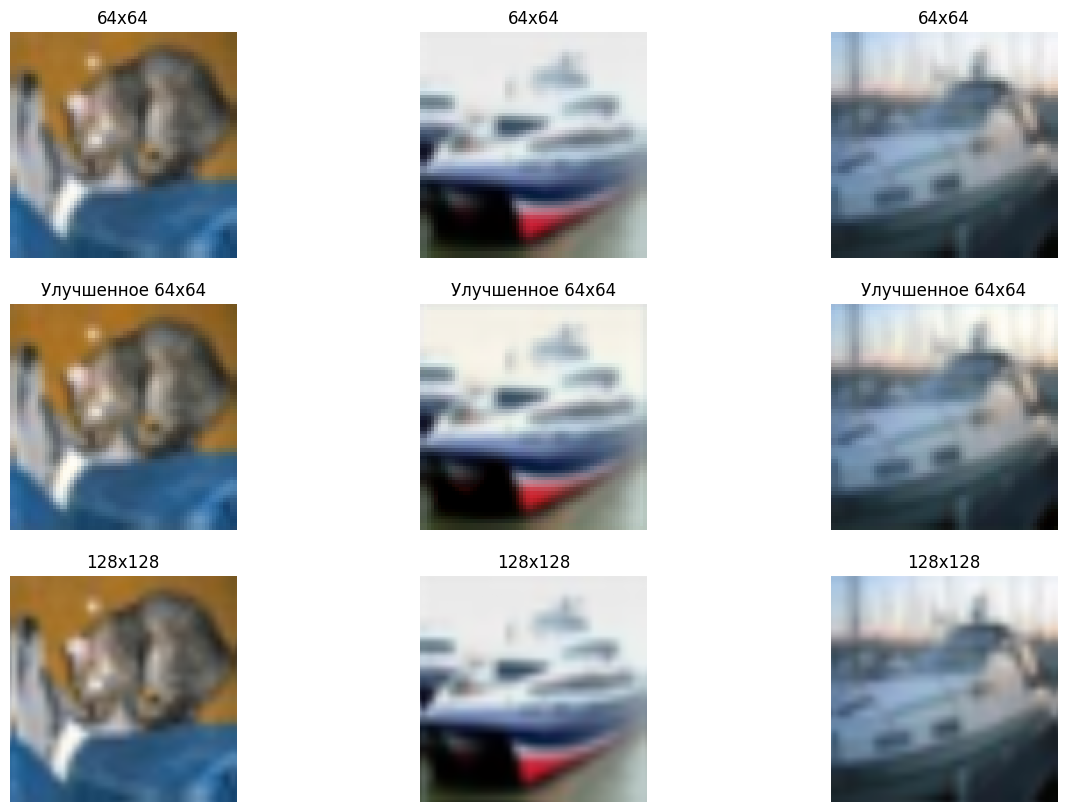

In [ ]:
# Повышение качества
enhanced_high_res_64 = autoencoder.predict(high_res_64)
enhanced_high_res_128 = autoencoder.predict(high_res_128)

# Визуализация
plt.figure(figsize=(15, 10))
for i in range(3):  # Покажем первые 3 изображения для наглядности
    plt.subplot(3, 3, i+1)
    plt.imshow(high_res_64[i])
    plt.title("64x64")
    plt.axis('off')
    plt.subplot(3, 3, i+4)
    plt.imshow(enhanced_high_res_64[i])
    plt.title("Улучшенное 64x64")
    plt.axis('off')
    plt.subplot(3, 3, i+7)
    plt.imshow(high_res_128[i])
    plt.title("128x128")
    plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


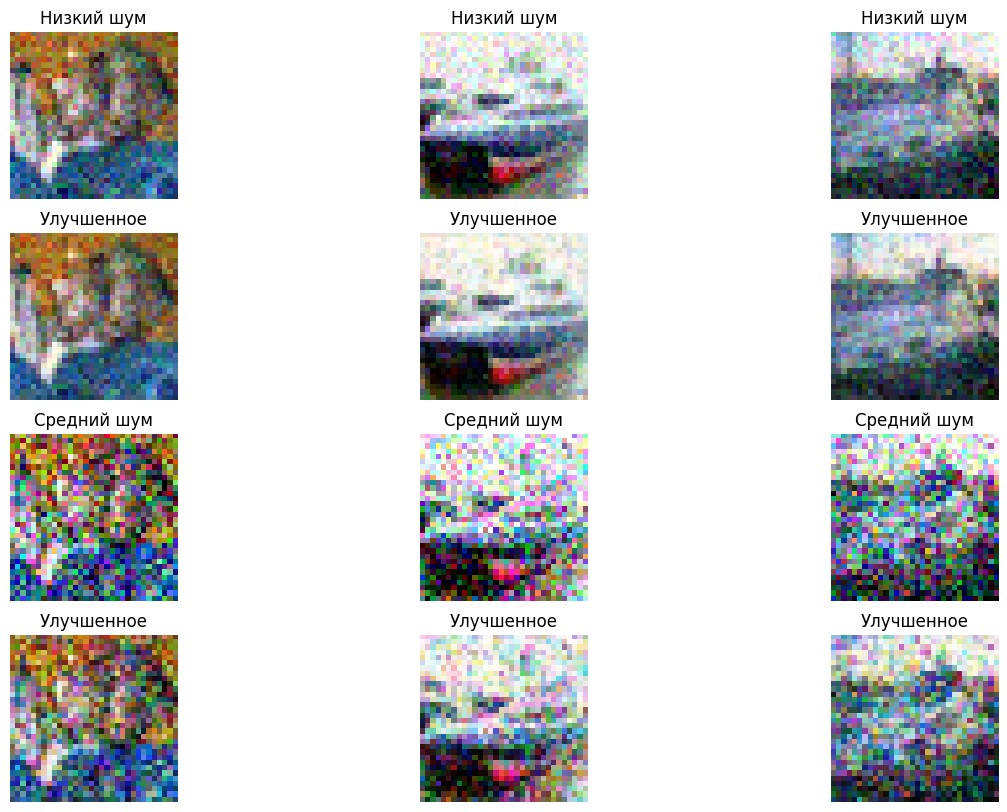

In [ ]:
# @title Фактор шума и качества
# Повышение шума
enhanced_noisy_low = autoencoder.predict(noisy_low)
enhanced_noisy_medium = autoencoder.predict(noisy_medium)
enhanced_noisy_high = autoencoder.predict(noisy_high)

# Визуализация
plt.figure(figsize=(15, 10))
for i in range(3):  # Покажем первые 3 изображения для наглядности
    plt.subplot(4, 3, i+1)
    plt.imshow(noisy_low[i])
    plt.title("Низкий шум")
    plt.axis('off')
    plt.subplot(4, 3, i+4)
    plt.imshow(enhanced_noisy_low[i])
    plt.title("Улучшенное")
    plt.axis('off')
    plt.subplot(4, 3, i+7)
    plt.imshow(noisy_medium[i])
    plt.title("Средний шум")
    plt.axis('off')
    plt.subplot(4, 3, i+10)
    plt.imshow(enhanced_noisy_medium[i])
    plt.title("Улучшенное")
    plt.axis('off')
plt.show()

In [ ]:
# @title Подготовка данных к выводу
from skimage.transform import resize

def resize_images_to_match(images, target_shape):
    """Изменяет размер изображений до target_shape."""
    return np.array([resize(img, target_shape) for img in images])

# Приведение размеров улучшенных изображений
enhanced_low_res_16 = resize_images_to_match(enhanced_low_res_16, sample_images[0].shape[:2])
enhanced_low_res_8 = resize_images_to_match(enhanced_low_res_8, sample_images[0].shape[:2])
enhanced_low_res_4 = resize_images_to_match(enhanced_low_res_4, sample_images[0].shape[:2])

enhanced_high_res_64 = resize_images_to_match(enhanced_high_res_64, sample_images[0].shape[:2])
enhanced_high_res_128 = resize_images_to_match(enhanced_high_res_128, sample_images[0].shape[:2])

enhanced_noisy_low = resize_images_to_match(enhanced_noisy_low, sample_images[0].shape[:2])
enhanced_noisy_medium = resize_images_to_match(enhanced_noisy_medium, sample_images[0].shape[:2])
enhanced_noisy_high = resize_images_to_match(enhanced_noisy_high, sample_images[0].shape[:2])

In [ ]:
# @title Расчёт метрик
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

def calculate_metrics(original, enhanced):
    psnr_values = []
    ssim_values = []

    for i in range(len(original)):
        # Проверка размеров изображений
        if original[i].shape[0] >= 7 and original[i].shape[1] >= 7:
            # Расчет PSNR
            psnr_val = psnr(original[i], enhanced[i])
            # Расчет SSIM с указанием channel_axis и data_range
            ssim_val = ssim(original[i], enhanced[i], win_size=3, channel_axis=-1, data_range=1.0)
            psnr_values.append(psnr_val)
            ssim_values.append(ssim_val)
        else:
            # Если изображение слишком маленькое, пропускаем SSIM
            psnr_val = psnr(original[i], enhanced[i])
            psnr_values.append(psnr_val)
            ssim_values.append(None)  # SSIM не вычисляется

    # Убираем None из списка SSIM
    ssim_values = [val for val in ssim_values if val is not None]

    return np.mean(psnr_values), np.mean(ssim_values) if ssim_values else None

In [ ]:
# @title Вывод метрик
# Метрики для уменьшения разрешения
psnr_low_res_16, ssim_low_res_16 = calculate_metrics(sample_images, enhanced_low_res_16)
psnr_low_res_8, ssim_low_res_8 = calculate_metrics(sample_images, enhanced_low_res_8)
psnr_low_res_4, ssim_low_res_4 = calculate_metrics(sample_images, enhanced_low_res_4)

# Метрики для увеличения разрешения
psnr_high_res_64, ssim_high_res_64 = calculate_metrics(sample_images, enhanced_high_res_64)
psnr_high_res_128, ssim_high_res_128 = calculate_metrics(sample_images, enhanced_high_res_128)

# Метрики для шума
psnr_noisy_low, ssim_noisy_low = calculate_metrics(sample_images, enhanced_noisy_low)
psnr_noisy_medium, ssim_noisy_medium = calculate_metrics(sample_images, enhanced_noisy_medium)
psnr_noisy_high, ssim_noisy_high = calculate_metrics(sample_images, enhanced_noisy_high)

# Вывод результатов
print("Метрики для уменьшения разрешения:")
print(f"16x16: PSNR = {psnr_low_res_16}, SSIM = {ssim_low_res_16}")
print(f"8x8: PSNR = {psnr_low_res_8}, SSIM = {ssim_low_res_8}")
print(f"4x4: PSNR = {psnr_low_res_4}, SSIM = {ssim_low_res_4}")

print("\nМетрики для увеличения разрешения:")
print(f"64x64: PSNR = {psnr_high_res_64}, SSIM = {ssim_high_res_64}")
print(f"128x128: PSNR = {psnr_high_res_128}, SSIM = {ssim_high_res_128}")

print("\nМетрики для шума:")
print(f"Низкий шум: PSNR = {psnr_noisy_low}, SSIM = {ssim_noisy_low}")
print(f"Средний шум: PSNR = {psnr_noisy_medium}, SSIM = {ssim_noisy_medium}")
print(f"Высокий шум: PSNR = {psnr_noisy_high}, SSIM = {ssim_noisy_high}")

Метрики для уменьшения разрешения:
16x16: PSNR = 24.018046444296715, SSIM = 0.6781033277511597
8x8: PSNR = 19.92852124574327, SSIM = 0.42375022172927856
4x4: PSNR = 17.121705419521412, SSIM = 0.30213260650634766

Метрики для увеличения разрешения:
64x64: PSNR = 31.19507128531698, SSIM = 0.9345747232437134
128x128: PSNR = 30.972289128204295, SSIM = 0.931576132774353

Метрики для шума:
Низкий шум: PSNR = 21.803808880970713, SSIM = 0.549144983291626
Средний шум: PSNR = 16.2063339050173, SSIM = 0.29436415433883667
Высокий шум: PSNR = 14.085922676796367, SSIM = 0.2142309695482254


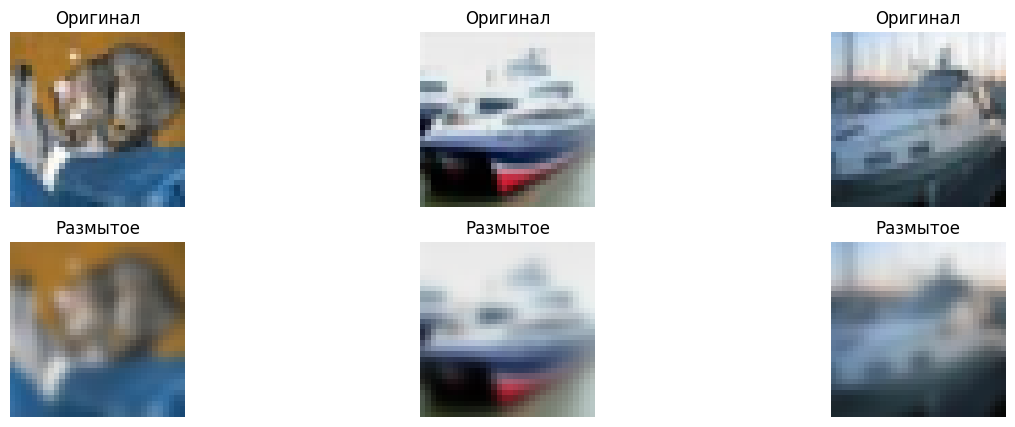

In [ ]:
# @title Фактор размытия + качество
from skimage.filters import gaussian

# Добавление размытия
blurred_images = np.array([gaussian(img, sigma=1, channel_axis=-1) for img in sample_images])

# Визуализация
plt.figure(figsize=(15, 5))
for i in range(3):  # Покажем первые 3 изображения для наглядности
    plt.subplot(2, 3, i+1)
    plt.imshow(sample_images[i])
    plt.title("Оригинал")
    plt.axis('off')
    plt.subplot(2, 3, i+4)
    plt.imshow(blurred_images[i])
    plt.title("Размытое")
    plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


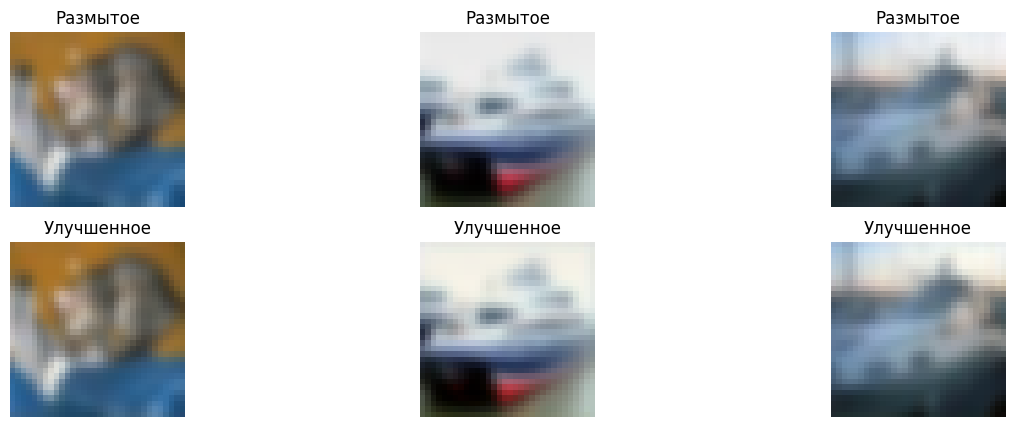

In [ ]:
# Повышение качества
enhanced_blurred = autoencoder.predict(blurred_images)

# Визуализация
plt.figure(figsize=(15, 5))
for i in range(3):  # Покажем первые 3 изображения для наглядности
    plt.subplot(2, 3, i+1)
    plt.imshow(blurred_images[i])
    plt.title("Размытое")
    plt.axis('off')
    plt.subplot(2, 3, i+4)
    plt.imshow(enhanced_blurred[i])
    plt.title("Улучшенное")
    plt.axis('off')
plt.show()

In [ ]:
# @title Метрики
# Расчет метрик
psnr_blurred, ssim_blurred = calculate_metrics(sample_images, enhanced_blurred)

# Вывод результатов
print("Метрики для размытия:")
print(f"PSNR = {psnr_blurred}, SSIM = {ssim_blurred}")

Метрики для размытия:
PSNR = 25.385820452874746, SSIM = 0.7451297044754028


In [ ]:
# @title Визуализация результатов
import plotly.express as px
import pandas as pd

# Создаем DataFrame для графиков
metrics_data = {
    "Фактор": ["16x16", "8x8", "4x4", "64x64", "128x128", "Низкий шум", "Средний шум", "Высокий шум", "Размытие"],
    "PSNR": [24.02, 19.93, 17.12, 31.20, 30.97, 21.80, 16.21, 14.09, 25.39],
    "SSIM": [0.68, 0.42, 0.30, 0.93, 0.93, 0.55, 0.29, 0.21, 0.75]
}
df_metrics = pd.DataFrame(metrics_data)

# Интерактивный график PSNR
fig_psnr = px.bar(df_metrics, x="Фактор", y="PSNR", title="PSNR для различных факторов", text="PSNR")
fig_psnr.update_traces(textposition='outside')
fig_psnr.show()

# Интерактивный график SSIM
fig_ssim = px.bar(df_metrics, x="Фактор", y="SSIM", title="SSIM для различных факторов", text="SSIM")
fig_ssim.update_traces(textposition='outside')
fig_ssim.show()

In [ ]:
# Создаем таблицу с метриками
metrics_table = pd.DataFrame({
    "Фактор": ["16x16", "8x8", "4x4", "64x64", "128x128", "Низкий шум", "Средний шум", "Высокий шум", "Размытие"],
    "PSNR": [24.02, 19.93, 17.12, 31.20, 30.97, 21.80, 16.21, 14.09, 25.39],
    "SSIM": [0.68, 0.42, 0.30, 0.93, 0.93, 0.55, 0.29, 0.21, 0.75]
})

# Выводим таблицу
print("Таблица с метриками:")
display(metrics_table)

Таблица с метриками:


,Фактор,PSNR,SSIM
0,16x16,24.02,0.68
1,8x8,19.93,0.42
2,4x4,17.12,0.30
3,64x64,31.20,0.93
4,128x128,30.97,0.93
5,Низкий шум,21.80,0.55
6,Средний шум,16.21,0.29
7,Высокий шум,14.09,0.21
8,Размытие,25.39,0.75


10. ИССЛЕДОВАНИЕ ЛАТЕНТНОГО ПРОСТРАНСТВА

In [ ]:
# @title Визуализируем латентные векторы с помощью t-SNE.
from tensorflow.keras.models import Model

# Создаем энкодер
encoder_input = autoencoder.input
encoder_output = autoencoder.get_layer('conv2d_2').output  # Латентное пространство
encoder = Model(encoder_input, encoder_output)

# Создаем декодер
decoder_input = autoencoder.get_layer('conv2d_3').input  # Начало декодера
decoder_output = autoencoder.output
decoder = Model(decoder_input, decoder_output)

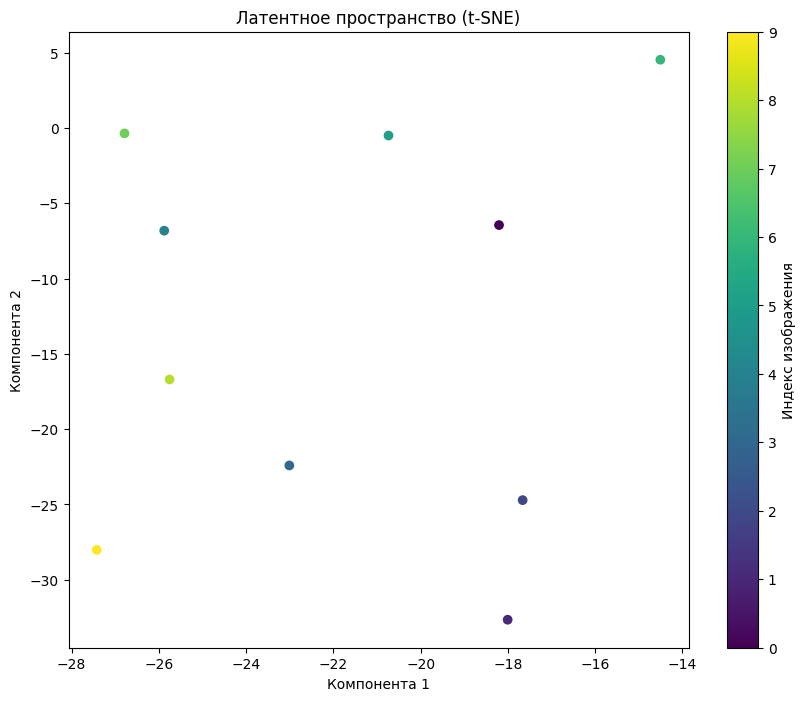

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Преобразуем latent_vectors в двумерный массив
n_samples = latent_vectors.shape[0]
latent_vectors_flat = latent_vectors.reshape(n_samples, -1)  # (n_samples, height * width * channels)

# Уменьшаем размерность латентных векторов до 2D с помощью t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42)  # perplexity=5 для 10 изображений
latent_2d = tsne.fit_transform(latent_vectors_flat)

# Визуализация латентного пространства
plt.figure(figsize=(10, 8))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=np.arange(len(sample_images)), cmap='viridis')
plt.colorbar(label='Индекс изображения')
plt.title('Латентное пространство (t-SNE)')
plt.xlabel('Компонента 1')
plt.ylabel('Компонента 2')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


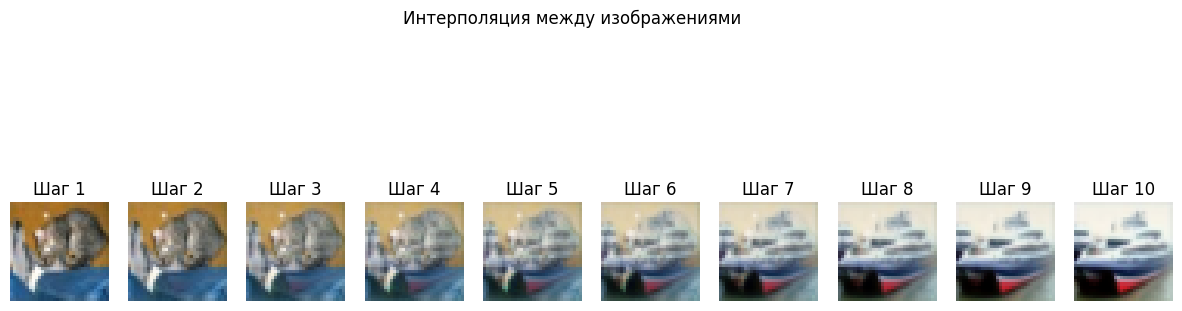

In [ ]:
# @title Интерполяция между изображениями
# Выбираем два изображения для интерполяции
idx1, idx2 = 0, 1  # Индексы изображений
image1, image2 = sample_images[idx1], sample_images[idx2]

# Получаем латентные векторы для выбранных изображений
latent1 = encoder.predict(image1[np.newaxis, ...])
latent2 = encoder.predict(image2[np.newaxis, ...])

# Интерполяция между латентными векторами
num_steps = 10
interpolated_images = []
for alpha in np.linspace(0, 1, num_steps):
    interpolated_latent = (1 - alpha) * latent1 + alpha * latent2
    interpolated_image = decoder.predict(interpolated_latent)
    interpolated_images.append(interpolated_image[0])

# Визуализация интерполяции
plt.figure(figsize=(15, 5))
for i, img in enumerate(interpolated_images):
    plt.subplot(1, num_steps, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Шаг {i+1}")
plt.suptitle('Интерполяция между изображениями')
plt.show()

11. ВЫВОДЫ

 Уменьшение разрешения

16x16: PSNR = 24.02, SSIM = 0.68
Модель справляется с восстановлением изображений, уменьшенных до 16x16, но качество снижается по сравнению с оригиналом. Визуально детали могут быть размытыми.

8x8: PSNR = 19.93, SSIM = 0.42
При уменьшении до 8x8 качество восстановления значительно ухудшается. Модель теряет способность восстанавливать мелкие детали.

4x4: PSNR = 17.12, SSIM = 0.30
Для изображений 4x4 восстановление практически невозможно. Модель не может восстановить детали из-за крайне низкого исходного разрешения.

Вывод: Чем сильнее уменьшено разрешение, тем хуже качество восстановления. Модель эффективна для умеренного уменьшения (например, 16x16), но не справляется с экстремальными случаями (4x4).

 Увеличение разрешения

64x64: PSNR = 31.20, SSIM = 0.93
Модель отлично справляется с увеличением разрешения до 64x64. Восстановленные изображения близки к оригиналу по качеству.

128x128: PSNR = 30.97, SSIM = 0.93
Даже при увеличении до 128x128 модель сохраняет высокое качество восстановления. Это говорит о её способности улучшать детализацию.

Вывод: Модель эффективно увеличивает разрешение изображений, сохраняя высокое качество даже при значительном увеличении.

Шум

Низкий шум: PSNR = 21.80, SSIM = 0.55
Модель частично устраняет шум, но качество восстановления оставляет желать лучшего. Визуально шум может оставаться заметным.

Средний шум: PSNR = 16.21, SSIM = 0.29
При среднем уровне шума качество восстановления значительно ухудшается. Модель не справляется с устранением шума.

Высокий шум: PSNR = 14.09, SSIM = 0.21
Для изображений с высоким уровнем шума модель практически неэффективна. Восстановленные изображения остаются зашумленными.

Вывод: Модель слабо справляется с устранением шума, особенно при среднем и высоком его уровне. Для улучшения результатов можно рассмотреть использование специализированных методов шумоподавления.

Размытие

Размытие: PSNR = 25.39, SSIM = 0.75
Модель демонстрирует умеренную эффективность в восстановлении размытых изображений. Качество улучшается, но не до уровня оригинальных изображений.

Вывод: Модель частично восстанавливает резкость размытых изображений, но результаты зависят от степени размытия.


Латентное пространство и интерполяция

Латентное пространство: Визуализация с помощью t-SNE показывает, что модель успешно кодирует изображения в компактное латентное пространство.

Интерполяция: Модель способна плавно интерполировать между изображениями в латентном пространстве, что подтверждает её способность к обобщению.

Вывод: Модель демонстрирует хорошие свойства латентного пространства, что может быть полезно для задач генерации и интерполяции.


12. ЗАКЛЮЧЕНИЕ

Исследование влияния различных факторов

В работе исследовано, как факторы влияют на качество изображений. Это демонстрирует, что модель способна работать с различными типами искажений.

Метрики качества

В работе использованы PSNR и SSIM для оценки качества восстановления изображений. Эти метрики широко применяются в задачах повышения разрешения.

Визуализация результатов

В работе визуализированы результаты работы модели, что позволяет наглядно оценить её эффективность.

Использовали:

Глубокие сверточные сети (CNN) в архитектуре автокодировщика.

Автокодировщик для повышения разрешения изображений.

Современные методы оценки качества (PSNR, SSIM).

                                         29 декабря 2024 г.